In [3]:
pip install --upgrade pip


     |████████████████████████████████| 1.5MB 8.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [8]:
!git clone https://github.com/ourownstory/neural_prophet.git

Cloning into 'neural_prophet'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 3277 (delta 4), reused 0 (delta 0), pack-reused 3263
Receiving objects: 100% (3277/3277), 49.91 MiB | 34.30 MiB/s, done.
Resolving deltas: 100% (2129/2129), done.


In [12]:
!cd /content/neural_prophet
!pwd

/content


In [14]:
import os
os.chdir('/content/neural_prophet')

!pwd

/content/neural_prophet


In [15]:
pip install .

Processing /content/neural_prophet
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 69 kB 5.0 MB/s 
  Created wheel for neuralprophet: filename=neuralprophet-0.2.7-py3-none-any.whl size=56155 sha256=fb4343c22e13bb83f7c103f68e9b44ac6965f99768796b2ff52b83d3a4e4615f
  Stored in directory: /tmp/pip-ephem-wheel-cache-95_ls1nj/wheels/1c/b0/b2/fb5e6db06611b87cd11016cb15b6b575f5462aa19df34a1980
Successfully built neuralprophet
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


INFO - (NP.config.__post_init__) - Trend reg threshold ignored due to reg lambda <= 0.
INFO - (NP.forecaster._handle_missing_data) - 1360 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 1360 NaN values in column y were auto-imputed.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

Epoch[400/400]: 100%|██████████| 400/400 [32:42<00:00,  4.91s/it, SmoothL1Loss=0.000117, MAE=0.738, RegLoss=0.0964]
WARNING - (NP.forecaster.make_future_dataframe) - Insufficient data for 3020 historic forecasts, reduced to 2020.
INFO - (NP.forecaster._handle_missing_data) - 1360 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 1360 NaN values in column y were auto-imputed.


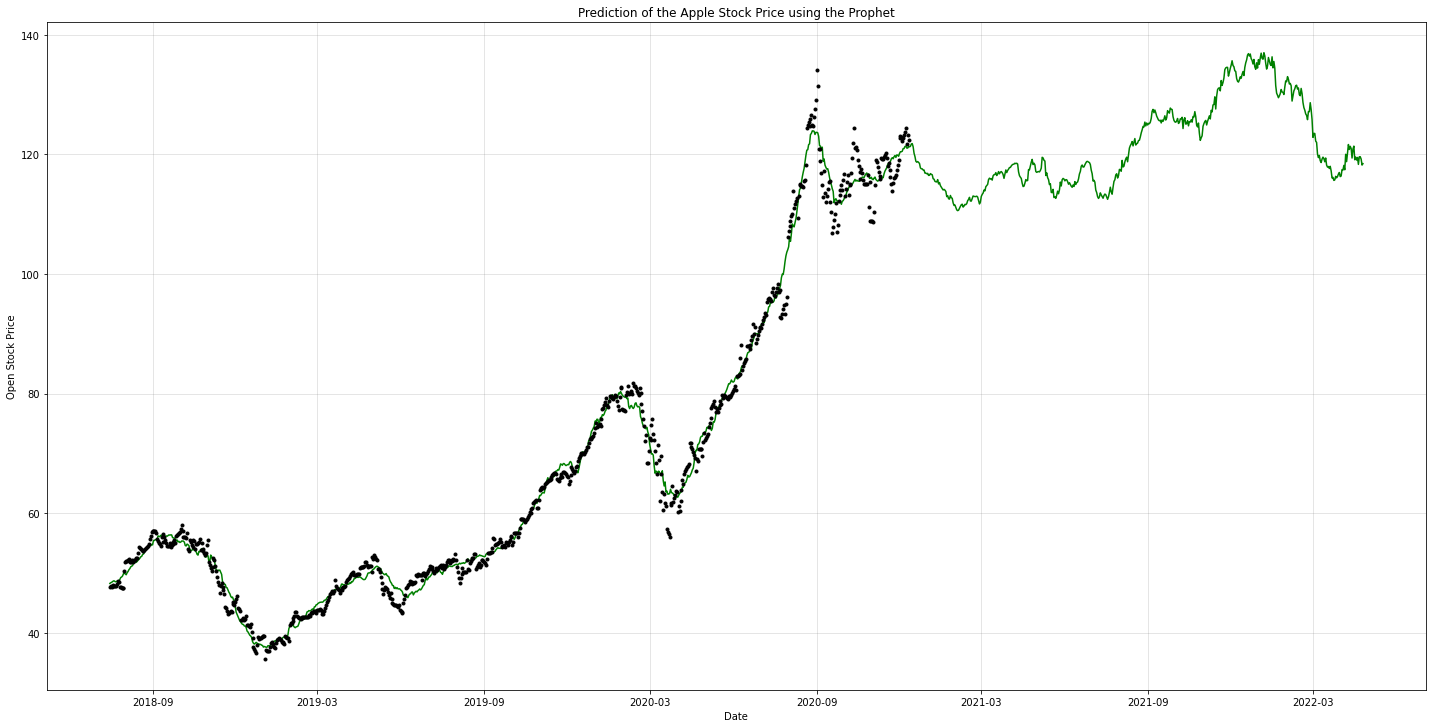

In [17]:
from neuralprophet import NeuralProphet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from pandas_datareader.data import DataReader

start = datetime.now() - relativedelta(years=12)
end = datetime.now()
# start = datetime(end.year, end.month, end.day-1000)


data = DataReader('AAPL', data_source='yahoo', start=start, end=end)
# Load the dataset using pandas
# data = pd.read_csv("../input/aapl-10122000/AAPL.csv") 

# data['Date'] = data.index
df = data.reset_index()

df = df[["Date","Close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
df = df.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset
# data.head(5)


# m = NeuralProphet(growth="discontinuous", 
#                   yearly_seasonality="auto",
#                   weekly_seasonality="auto",
#                   daily_seasonality=True,
#                   n_forecasts=500,
#                   n_lags=1000,
#                   learning_rate=0.001,
#                   epochs=200,
# )
m = NeuralProphet(growth="discontinuous",  # Determine trend types: 'linear', 'discontinuous', 'off'
                changepoints=None, # list of dates that may include change points (None -> automatic )
                n_changepoints=5,
                changepoints_range=0.8,
                trend_reg=0,
                trend_reg_threshold=True,
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=True,
                seasonality_mode="additive",
                seasonality_reg=0,
                n_forecasts=500,
                n_lags=1000,
                num_hidden_layers=4,
                d_hidden=512,     # Dimension of hidden layers of AR-Net
                ar_sparsity=0.01,  # Sparcity in the AR coefficients
                learning_rate=0.001,
                epochs=400,
                loss_func="Huber",
                normalize="auto",  # Type of normalization ('minmax', 'standardize', 'soft', 'off')
                impute_missing=True,
                # log_level=None, # Determines the logging level of the logger object
)

metrics = m.fit(df, freq="D")
future = m.make_future_dataframe(df, periods=500, n_historic_predictions=len(df))
forecast = m.predict(future)

beta = forecast.iloc[3500:4882,[0, 1, 1000, 1001, 1501, 1502, 1503, 1504]]

beta = beta.rename(columns = {"yhat500":"yhat1","residual500":"residual1", "ar500":"ar1"})


m.plot(beta, figsize=(20,10))
plt.gca().get_lines()[0].set_color("green")

plt.title("Prediction of the Apple Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Open Stock Price")
plt.show()

In [19]:
import pickle
pkl_path = "NeuralProphetOpen.pkl"
with open(pkl_path, "wb") as f:
    # Pickle the 'Prophet' model using the highest protocol available.
    pickle.dump(m, f)

# save the dataframe
forecast.to_pickle("forecastNeuralProphetOpen.pkl")
print("*** Data Saved ***")

*** Data Saved ***
*** Data Saved ***


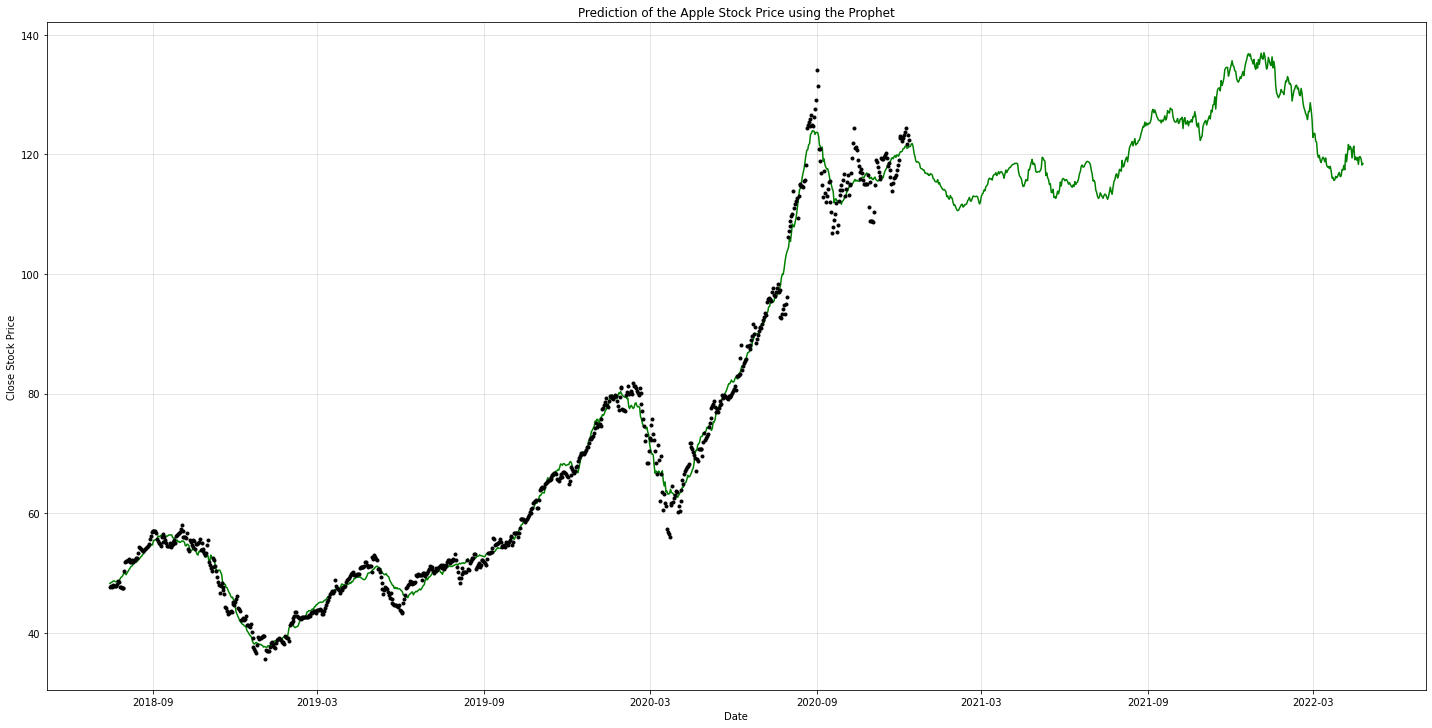

In [70]:
m.plot(beta, figsize=(20,10))
ax = plt.gca()
plt.gca().get_lines()[0].set_color("green")

plt.title("Prediction of the Apple Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

In [33]:
import pandas as pd


Actual_point = pd.DataFrame(list(zip(ax.lines[1].get_xdata(), ax.lines[1].get_ydata())), columns=["Date", "Close"])
Actual_point.to_csv("actual.csv")

In [38]:
forecast_point = pd.DataFrame(list(zip(ax.lines[0].get_xdata(), ax.lines[0].get_ydata())), columns=["Date", "Close"])
forecast_point.to_csv("forecast.csv")



100


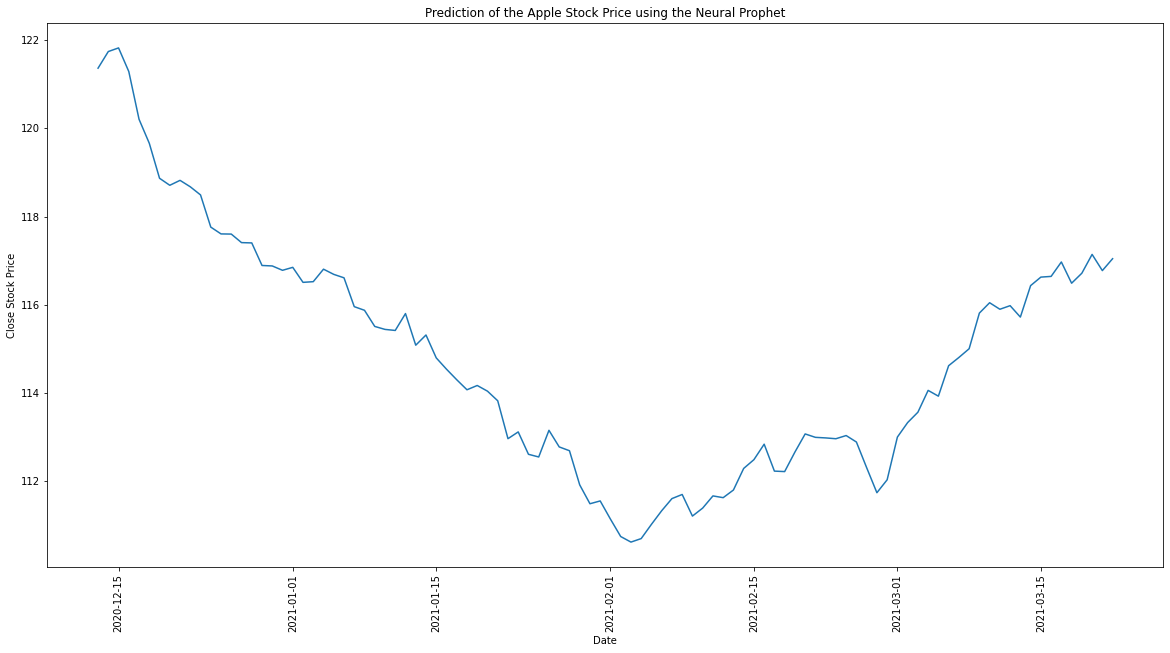

In [73]:
from datetime import datetime 
import matplotlib.pyplot as plt
import numpy as np


future = int(input())

today_index = forecast_point[forecast_point["Date"] == str(datetime.today().date())].index.item()

post_index = today_index + future

all_index = np.arange(today_index, post_index)

x = []
y = []

for i in all_index:
  x = np.append(x, forecast_point.iloc[i, 0])
  y = np.append(y, forecast_point.iloc[i, 1])


plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.xticks(rotation=90)
plt.title("Prediction of the Apple Stock Price using the Neural Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()



In [85]:
from IPython.display import HTML
import plotly.express as px

future_df = pd.DataFrame(list(zip(x, y)), columns=["Date", "Close"])
fig = px.line(future_df, x="Date", y="Close", title="Forecast of Apple Stock using Neural Prophet")
fig.show()

In [80]:
highest = y.max()
lowest = y.min()

highest_date = forecast_point[forecast_point["Close"] == highest]["Date"]
lowest_date = forecast_point[forecast_point["Close"] == lowest]["Date"]
